<font size=6><b>Seminar 2 - Difference equations</b></font><br/>
<font size=5>2020-10-22</b><br/>
<font size=3>Michal Kubišta<br/>
    <michal.kubista@nielsen.com></font>

# Content
<font size=3>
    <ol>
        <li>Home assignment - example solution</li>
        <li>Quantitative solutions</li>
        <li>Qualitative solutions</li>
        <li>Cobweb model</li>
    </ol>
</font>

In [12]:
import inspect

import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sp.init_printing()

---
# Home assignment - example solution
---

---
# Quantitative solutions
---

In [2]:
t = sp.Symbol('t', integer = True)
y = sp.Function('y')

yeq = sp.Eq(y(t+2) - 6*y(t+1) + 5*y(t), 8)
yeq

In [3]:
sp.rsolve(yeq, y(t))

---
# Qualitative solutions
---

In [4]:
t = sp.Symbol('t', integer = True)
y = sp.Function('y')
rec = sp.Eq(y(t+1), y(t)**2)
rec

## What (graphical) elements do we need for a phase diagram?
- axes
- plot of difference equation
- 45° line (xy line)
- arrows

The first 3 points are simple to describe.  
The last one is slightly more complex -> but I have a gift for you


In [5]:
# the gift
def path(fun, start, iter):
    x = np.zeros(2*iter+1)
    y = np.zeros(2*iter+1)
    x[0] = start
    y[0] = 0
    i = 1
    while i < 2*iter:
        x[i] = x[i-1]
        y[i] = fun(x[i])
        x[i+1] = y[i]
        y[i+1] = y[i]
        i += 2
    u = np.zeros(len(x)-1)
    v = np.zeros(len(y)-1)
    for i in range(len(x)-1):
        u[i] = x[i+1] - x[i]
        v[i] = y[i+1] - y[i]
    return(x, y, u, v)


In [6]:
# prepare a python function
recF = sp.lambdify(y(t), rec.rhs, "numpy")
display(
    rec,
    inspect.findsource(recF)
    )

(['def _lambdifygenerated(_Dummy_195):\n', '    return (_Dummy_195**2)\n'], 0)

## Phase diagram

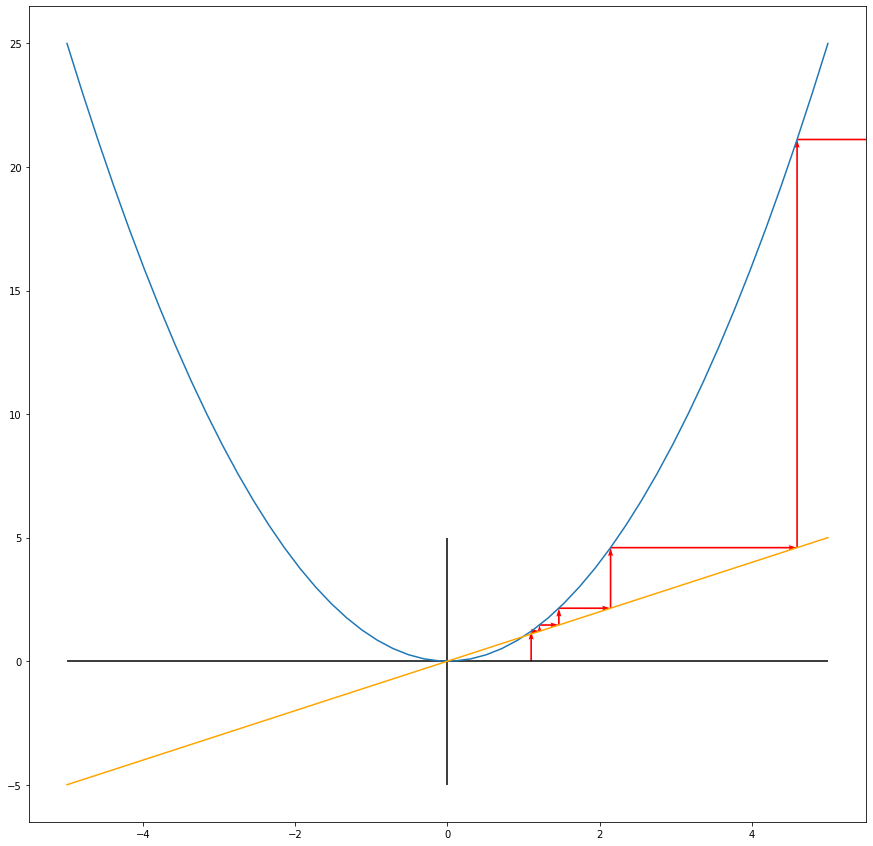

In [7]:
tval = np.linspace(-5, 5, 50)
x, y, u, v = path(recF, 1.1, 5)

plt.figure(figsize=(15,15))
plt.plot(tval, recF(tval))
plt.plot(tval, tval, color = 'orange')
plt.vlines(0, -5, 5, color = 'black')
plt.hlines(0, -5, 5, color = 'black')
plt.quiver(x[:-1],y[:-1], u, v,  angles='xy', scale_units='xy', scale=1, width = 0.002, color = 'red')

---
# Cobweb model
---

In [8]:
Qd = sp.Symbol('Q_d')                # quantity demanded
Qs = sp.Symbol('Q_s')                # quantity supplied 
t = sp.Symbol('t', integer = True)   # time
p = sp.Symbol('p')                   # price
a = sp.Symbol('a')                   # quantity demanded at zero price
b = sp.Symbol('b')                   # price sensitivity of demand (D slope)
c = sp.Symbol('c')                   # quantity supplied at zero price
d = sp.Symbol('d')                   # price sensitivity of supply (S slope)

In [13]:
demand = sp.Eq(Qd, a - b*p(t))
supply = sp.Eq(Qs, c + d*p(t-1))
display(demand, supply)

TypeError: 'Symbol' object is not callable

In [ ]:
# let's work with a specific case
# substitute the parameters with specific values
dem = demand.subs([(a, 150), (b, 12)])
sup = supply.subs([(c, 5),(d, 8)])
display(dem,sup)

In [10]:
def cobpath(dem, sup, price, iter):
    """
    Find the path of reaction of supply and demand
  
    This function calculates the points on the curves, that define the steps of how S reacts to D and wise-versa
    and finds the vectors that connect these points.
    It returns a tuple in a format suitable for `matplotlib.pyplot.quiver()`
  
    Parameters
    ----------
    dem (sympy.Eq):
        sympy equation describing the demand with:
            - quantity on the LHS
            - expression containing `p(t)` and constants on the RHS
    
     sup (sympy.Eq):
        sympy equation describing the demand with:
            - quantity on the LHS
            - expression containing `p(t-1)` and constants on the RHS

    price (float):
        starting price

    iter (int):
        number of reactions to be calculated
  
    Returns
    ----------
    tuple(P, Q, u, v, demf, supf):
        P (numpy.ndarray):
            array of prices (price coordinates) for each point

        Q (numpy.ndarray):
            array of qunatities (quantity coordinates) for each point

        u (numpy.ndarray):
            array of price coordinate of the vectors (arrows)

        v (numpy.ndarray):
            array of qunatity coordinate of the vectors (arrows)
        
        demf (function(float) -> float):
            lamdified demand function `D(p) = q_d`
        
        supf (function(float) -> float):
            lamdified supply function `S(p) = q_d`
    """
    demf = sp.lambdify(p(t), dem.rhs, "numpy")                   # D(p)  = q_d    - demand function
    supf = sp.lambdify(p(t-1), sup.rhs, "numpy")                 # S(p)  = q_s    - supply function
    idemf = sp.lambdify(Qd, sp.solve(dem, p(t))[0], "numpy")     # ID(q) = p_d    - inverse demand
    isupf = sp.lambdify(Qs, sp.solve(sup, p(t-1))[0], "numpy")   # IS(q) = p_s    - inverse supply

    Q = np.zeros(2*iter+1)
    P = np.zeros(2*iter+1)
    
    # start at given price and quantity supplied at the price
    P[0] = price
    Q[0] = 0

    # first, we find the reaction points [p_t, s_t] on the D and S curves
    i = 1
    while i < 2*iter:
        Q[i] = supf(P[i-1])      # find quantity supplied at the price
        P[i] = P[i-1]
        P[i+1] = idemf(Q[i])     # find the price for demand to purchase the supplied quantity
        Q[i+1] = Q[i] 
        i += 2
    
    # second, we define the vectors (arrows) that will connect these points
    u = np.zeros(len(P)-1)
    v = np.zeros(len(Q)-1)
    for i in range(len(P)-1):
        u[i] = P[i+1] - P[i]
        v[i] = Q[i+1] - Q[i]
    return(P, Q, u, v, demf, supf)

In [11]:
tvals = np.linspace(0, 13)
P, Q, u, v, dem_f, sup_f = cobpath(dem, sup, 8.5, 10)

plt.figure(figsize=(20,20))
plt.plot(tvals, dem_f(tvals), label = 'supply')
plt.plot(tvals, sup_f(tvals), label = 'demand')
plt.text(max(tvals),sup_f(tvals.max())-5, 'supply')
plt.text(max(tvals),dem_f(tvals.max())+5, 'demand')
plt.quiver(P[:-1], Q[:-1], u, v, angles='xy', scale_units='xy', scale=1, width = 0.002, color = 'red')

NameError: name 'dem' is not defined

Switching the axes is very simple - just switch coordinates:

In [ ]:
tvals = np.linspace(0, 13)
P, Q, u, v, dem_f, sup_f = cobpath(dem, sup, 8.5, 10)

plt.figure(figsize=(20,20))
plt.plot(dem_f(tvals), tvals, label = 'supply')
plt.plot(sup_f(tvals), tvals, label = 'demand')
plt.quiver(Q[:-1], P[:-1], v, u, angles='xy', scale_units='xy', scale=1, width = 0.002, color = 'red')